In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from paddleocr import PaddleOCR, draw_ocr

In [2]:
FONT = "C:\\Users\\ADMIN\\Desktop\\Slide_School\\SlideKy7\\PBL6\\Preparation\\latin.ttf"

In [3]:
detector = PaddleOCR(use_angle_cls = False, lang = "vi", use_gpu = False)

[2024/10/24 08:57:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batc

In [4]:
config = Cfg.load_config_from_name('vgg_transformer')
config['cnn']['pretrained'] = True
config['predictor']['beamsearch'] = True
config['device'] = 'cpu' # mps

recognitor = Predictor(config)

Model weight C:\Users\ADMIN\AppData\Local\Temp\vgg_transformer.pth exsits. Ignore download!


## `Inference`

In [5]:
def predict(recognitor, detector, img_path, save_path, padding=4, dpi=100):
    img = cv2.imread(img_path)
    result = detector.ocr(img_path, cls=False, det=True, rec=False)
    result = result[:][:][0]

    boxes = []
    for line in result:
        boxes.append([[int(line[0][0]), int(line[0][1])], [int(line[2][0]), int(line[2][1])]])
    boxes = boxes[::-1]

    padding = 4
    for box in boxes:
        box[0][0] = box[0][0] - padding
        box[0][1] = box[0][1] - padding
        box[1][0] = box[1][0] + padding
        box[1][1] = box[1][1] + padding

    texts = []
    for box in boxes:
        cropped_image = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        try:
            cropped_image = Image.fromarray(cropped_image)
        except:
            continue
        rec_result = recognitor.predict(cropped_image)
        text = rec_result
        texts.append(text)

    def get_rectangle_points(x1, y1, x2, y2):
        x_tl = x1
        y_tl = y2
        x_br = x2
        y_br = y1
        return [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    _boxes = [get_rectangle_points(boxe[0][0], boxe[0][1], boxe[1][0], boxe[1][1]) for boxe in boxes]

    #img = draw_ocr(img, _boxes)
    img = draw_ocr(img, _boxes, texts, scores=None, font_path=FONT)
    img_name = img_path.split('/')[-1]
    cv2.imwrite(os.path.join(save_path, img_name), img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    height, width, depth = img.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')

    plt.show()
    return boxes, texts

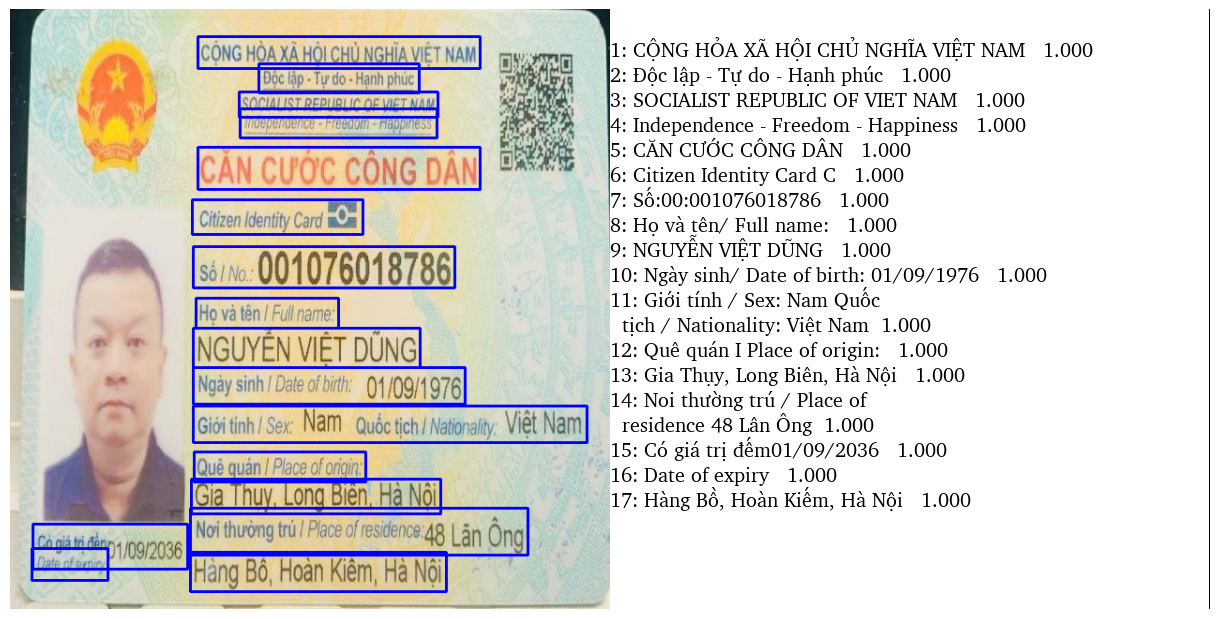

In [6]:
input_path = './images/image4.jpg'
output_path = './output'
# Predict
boxes, texts = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)

In [7]:
texts

['CỘNG HỎA XÃ HỘI CHỦ NGHĨA VIỆT NAM',
 'Độc lập - Tự do - Hạnh phúc',
 'SOCIALIST REPUBLIC OF VIET NAM',
 'Independence - Freedom - Happiness',
 'CĂN CƯỚC CÔNG DÂN',
 'Citizen Identity Card C',
 'Số:00:001076018786',
 'Họ và tên/ Full name:',
 'NGUYỄN VIỆT DŨNG',
 'Ngày sinh/ Date of birth: 01/09/1976',
 'Giới tính / Sex: Nam Quốc tịch / Nationality: Việt Nam',
 'Quê quán I Place of origin:',
 'Gia Thụy, Long Biên, Hà Nội',
 'Noi thường trú / Place of residence 48 Lân Ông',
 'Có giá trị đếm01/09/2036',
 'Date of expiry',
 'Hàng Bồ, Hoàn Kiếm, Hà Nội']